In [16]:
import pandas as pd
from google.colab import auth
auth.authenticate_user()
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [17]:
project_id = 'apiwats-project'
sql ='''
SELECT CUST_CODE,
SUM(SPEND) AS TOTAL_SALES,
COUNT(DISTINCT BASKET_ID) AS TOTAL_VISIT
FROM `apiwats-project.my_dataset.my_market`
WHERE CUST_CODE IS NOT NULL
GROUP BY CUST_CODE'''
df = pd.io.gbq.read_gbq(sql , project_id=project_id,verbose=False, dialect="standard")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


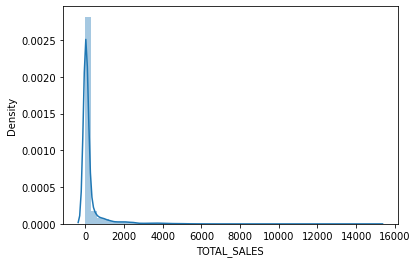

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


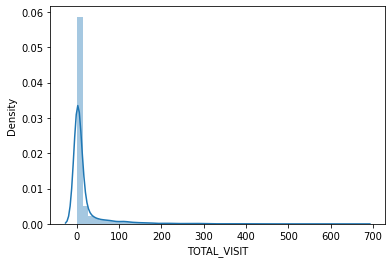

In [18]:

for i, col in enumerate(df.columns[1:]):
  plt.figure(i)
  sns.distplot(df[col])
  plt.show()

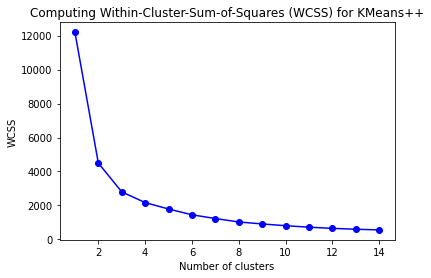

In [19]:
df_std = pd.DataFrame(StandardScaler().fit_transform(df[df.columns[1:]]))
df_std.head(5)

wcss = []
N = range(1, 15)
for i in N:
  kmeans = KMeans(n_clusters=i)
  kmeans.fit_predict(df_std)
  wcss.append(kmeans.inertia_)

plt.plot(N, wcss, 'bo-')
plt.title("Computing Within-Cluster-Sum-of-Squares (WCSS) for KMeans++")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [47]:
#let's choose k = 7
cluster = KMeans(n_clusters=6)
df['cluster'] = cluster.fit_predict(df_std)

In [48]:
df.head()

,CUST_CODE,TOTAL_SALES,TOTAL_VISIT,cluster
0,CUST0000065412,275.26,15,0
1,CUST0000644893,3726.78,154,1
2,CUST0000863361,190.79,32,0
3,CUST0000543374,915.17,33,2
4,CUST0000063931,1478.05,124,5


In [49]:
dfCluster = df.groupby('cluster', as_index=False).mean()
dfCluster['NO_CUST'] = df[['cluster','CUST_CODE']].groupby('cluster').count()
dfCluster

,cluster,TOTAL_SALES,TOTAL_VISIT,NO_CUST
0,0,44.356401,4.746044,5182
1,1,3959.601829,174.987805,82
2,2,613.172220,54.559921,509
3,3,2074.813692,290.907692,65
4,4,5969.815000,482.812500,16
5,5,1641.491382,117.195122,246


<Figure size 432x288 with 0 Axes>

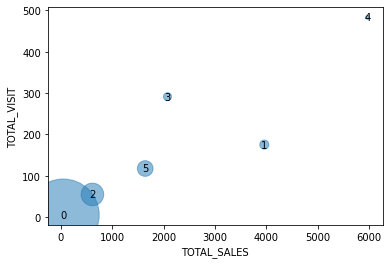

In [51]:
plt.figure()
fig, ax = plt.subplots()
ax.scatter(dfCluster['TOTAL_SALES'], dfCluster['TOTAL_VISIT'],
s=dfCluster['NO_CUST'], alpha = 0.5)
ax.set_xlabel("TOTAL_SALES")
ax.set_ylabel("TOTAL_VISIT")
for i, txt in enumerate(dfCluster['cluster']):
  ax.annotate(txt, (dfCluster['TOTAL_SALES'][i],
dfCluster["TOTAL_VISIT"][i]), horizontalalignment='center',verticalalignment='center')
plt.show()

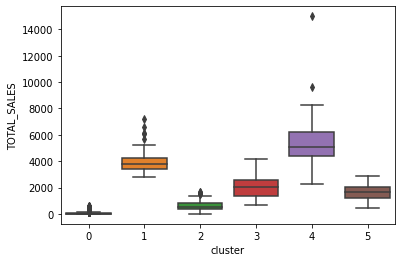

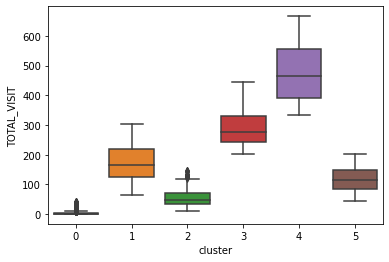

In [52]:
for i, col in enumerate(df.columns[1:-1]):
  sns.boxplot(x="cluster", y =col, data=df)
  plt.show()

In [53]:
predictors = df.iloc[:,1:-1]
targets = df.iloc[:,-1:]
scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy',
random_state = 42)
classifier.fit(predictors_scaled, targets.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [54]:
importances = list(classifier.feature_importances_)
feature_list = list(predictors.columns)
feature_importances = [(feature, round(importance, 2)) for feature,
importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1],
reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in
feature_importances];

Variable: TOTAL_SALES          Importance: 0.55
Variable: TOTAL_VISIT          Importance: 0.45
